In [2]:
import polars as pl
import os
from pathlib import Path

In [209]:
FOLDER = r"C:\\Users\\johan\\OneDrive\\Documents\\Python\\Python\\SilverStone"

In [3]:
path = Path("TrackData.csv")
df = pl.read_csv(path)
df.describe()

statistic,x_m,y_m,w_tr_right_m,w_tr_left_m
str,f64,f64,f64,f64
"""count""",1178.0,1178.0,1178.0,1178.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",499.955727,422.160986,6.91325,6.903748
"""std""",296.582725,513.272093,0.502209,0.46919
"""min""",-59.443563,-531.787771,5.415,5.753
"""25%""",223.900974,-2.673913,6.662,6.608
"""50%""",528.367204,422.172969,6.882,6.866
"""75%""",771.00166,882.154398,7.094,7.094
"""max""",960.872993,1192.3602,8.851,8.99


In [4]:
#Create and add the lanes
ldf = df.lazy()
aldf = ldf.with_columns([
    (pl.col("x_m").shift(-1) - pl.col("x_m").shift(1)).fill_null(strategy="forward").fill_null(strategy="backward").alias("x_dir"),
    (pl.col("y_m").shift(-1) - pl.col("y_m").shift(1)).fill_null(strategy="forward").fill_null(strategy="backward").alias("y_dir"),
    (pl.col("w_tr_left_m") + pl.col("w_tr_right_m")).alias("width")
]).with_columns([
    (pl.col("x_dir")*pl.col("x_dir") + pl.col("y_dir")*pl.col("y_dir")).sqrt().alias("norm_dir")
]).with_columns([
    (pl.col("x_dir")/pl.col("norm_dir")).alias("x_udir"),
    (pl.col("y_dir")/pl.col("norm_dir")).alias("y_udir")
])

N_LANES = 11
lane_factors = [-0.5 + i / (N_LANES - 1) for i in range(N_LANES)]
print(lane_factors)
aldf = aldf.with_columns(
        [(pl.col("x_m") + pl.lit(f) * pl.col("width") * pl.col("y_udir")).alias(f"x_lane{i}") for i, f in enumerate(lane_factors)] +
        [(pl.col("y_m") - pl.lit(f) * pl.col("width") * pl.col("x_udir")).alias(f"y_lane{i}") for i, f in enumerate(lane_factors)]
    )

lanesdfd = aldf.collect()
lanesdfd.describe()
lanesdfd

[-0.5, -0.4, -0.3, -0.2, -0.09999999999999998, 0.0, 0.09999999999999998, 0.19999999999999996, 0.30000000000000004, 0.4, 0.5]


x_m,y_m,w_tr_right_m,w_tr_left_m,x_dir,y_dir,width,norm_dir,x_udir,y_udir,x_lane0,x_lane1,x_lane2,x_lane3,x_lane4,x_lane5,x_lane6,x_lane7,x_lane8,x_lane9,x_lane10,y_lane0,y_lane1,y_lane2,y_lane3,y_lane4,y_lane5,y_lane6,y_lane7,y_lane8,y_lane9,y_lane10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3.439354,-0.495322,6.556,6.536,5.862596,8.10221,13.092,10.000792,0.586213,0.810157,-1.863933,-0.803275,0.257382,1.318039,2.378697,3.439354,4.500011,5.560669,6.621326,7.681983,8.742641,3.342029,2.574559,1.807089,1.039619,0.272148,-0.495322,-1.262792,-2.030263,-2.797733,-3.565203,-4.332673
6.370784,3.555763,6.558,6.537,5.862596,8.10221,13.095,10.000792,0.586213,0.810157,1.066282,2.127182,3.188083,4.248983,5.309884,6.370784,7.431684,8.492585,9.553485,10.614386,11.675286,7.393994,6.626348,5.858701,5.091055,4.323409,3.555763,2.788117,2.020471,1.252825,0.485178,-0.282468
9.30195,7.606888,6.56,6.538,5.862087,8.102292,13.098,10.00056,0.586176,0.810184,3.996056,5.057235,6.118414,7.179592,8.240771,9.30195,10.363129,11.424308,12.485486,13.546665,14.607844,11.445754,10.677981,9.910207,9.142434,8.374661,7.606888,6.839115,6.071342,5.303569,4.535795,3.768022
12.232871,11.658055,6.562,6.539,5.861618,8.10238,13.101,10.000356,0.586141,0.810209,6.925596,7.987051,9.048506,10.109961,11.171416,12.232871,13.294326,14.355781,15.417236,16.478691,17.540146,15.497571,14.729668,13.961765,13.193861,12.425958,11.658055,10.890152,10.122249,9.354345,8.586442,7.818539
15.163568,15.709268,6.564,6.54,5.861189,8.102473,13.104,10.00018,0.586108,0.810233,9.854923,10.916652,11.978381,13.04011,14.101839,15.163568,16.225297,17.287026,18.348755,19.410484,20.472213,19.54945,18.781413,18.013377,17.245341,16.477304,15.709268,14.941232,14.173195,13.405159,12.637123,11.869086
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-11.222438,-20.750233,6.535,6.559,5.866447,8.101822,13.094,10.002736,0.586484,0.809961,-16.52525,-15.464688,-14.404125,-13.343563,-12.283,-11.222438,-10.161876,-9.101313,-8.040751,-6.980188,-5.919626,-16.910521,-17.678463,-18.446406,-19.214348,-19.982291,-20.750233,-21.518175,-22.286118,-23.05406,-23.822003,-24.589945
-8.289395,-16.699311,6.54,6.553,5.865724,8.101872,13.093,10.002352,0.586434,0.809997,-13.592038,-12.53151,-11.470981,-10.410452,-9.349924,-8.289395,-7.228866,-6.168338,-5.107809,-4.04728,-2.986752,-12.860218,-13.628036,-14.395855,-15.163674,-15.931492,-16.699311,-17.46713,-18.234948,-19.002767,-19.770586,-20.538404
-5.356714,-12.648361,6.544,6.548,5.865019,8.10193,13.092,10.001986,0.586385,0.810032,-10.659184,-9.59869,-8.538196,-7.477702,-6.417208,-5.356714,-4.29622,-3.235726,-2.175232,-1.114738,-0.054244,-8.809882,-9.577578,-10.345273,-11.112969,-11.880665,-12.648361,-13.416057,-14.183753,-14.951449,-15.719144,-16.48684


In [5]:
import plotly.graph_objects as go
fig = go.Figure()

for i in range(N_LANES):
    fig.add_trace(go.Scatter(
        x = lanesdfd["x_lane" + str(i)].to_numpy(),
        y = lanesdfd["y_lane" + str(i)].to_numpy(),
        mode = "markers",
        marker  = dict(size=3),
        name = "lane " + str(i)
    ))

fig.update_layout(
    width=1200,
    height=1000,
    title="Track Lanes",
    xaxis=dict(scaleanchor="y", scaleratio=1),
)

fig.show()

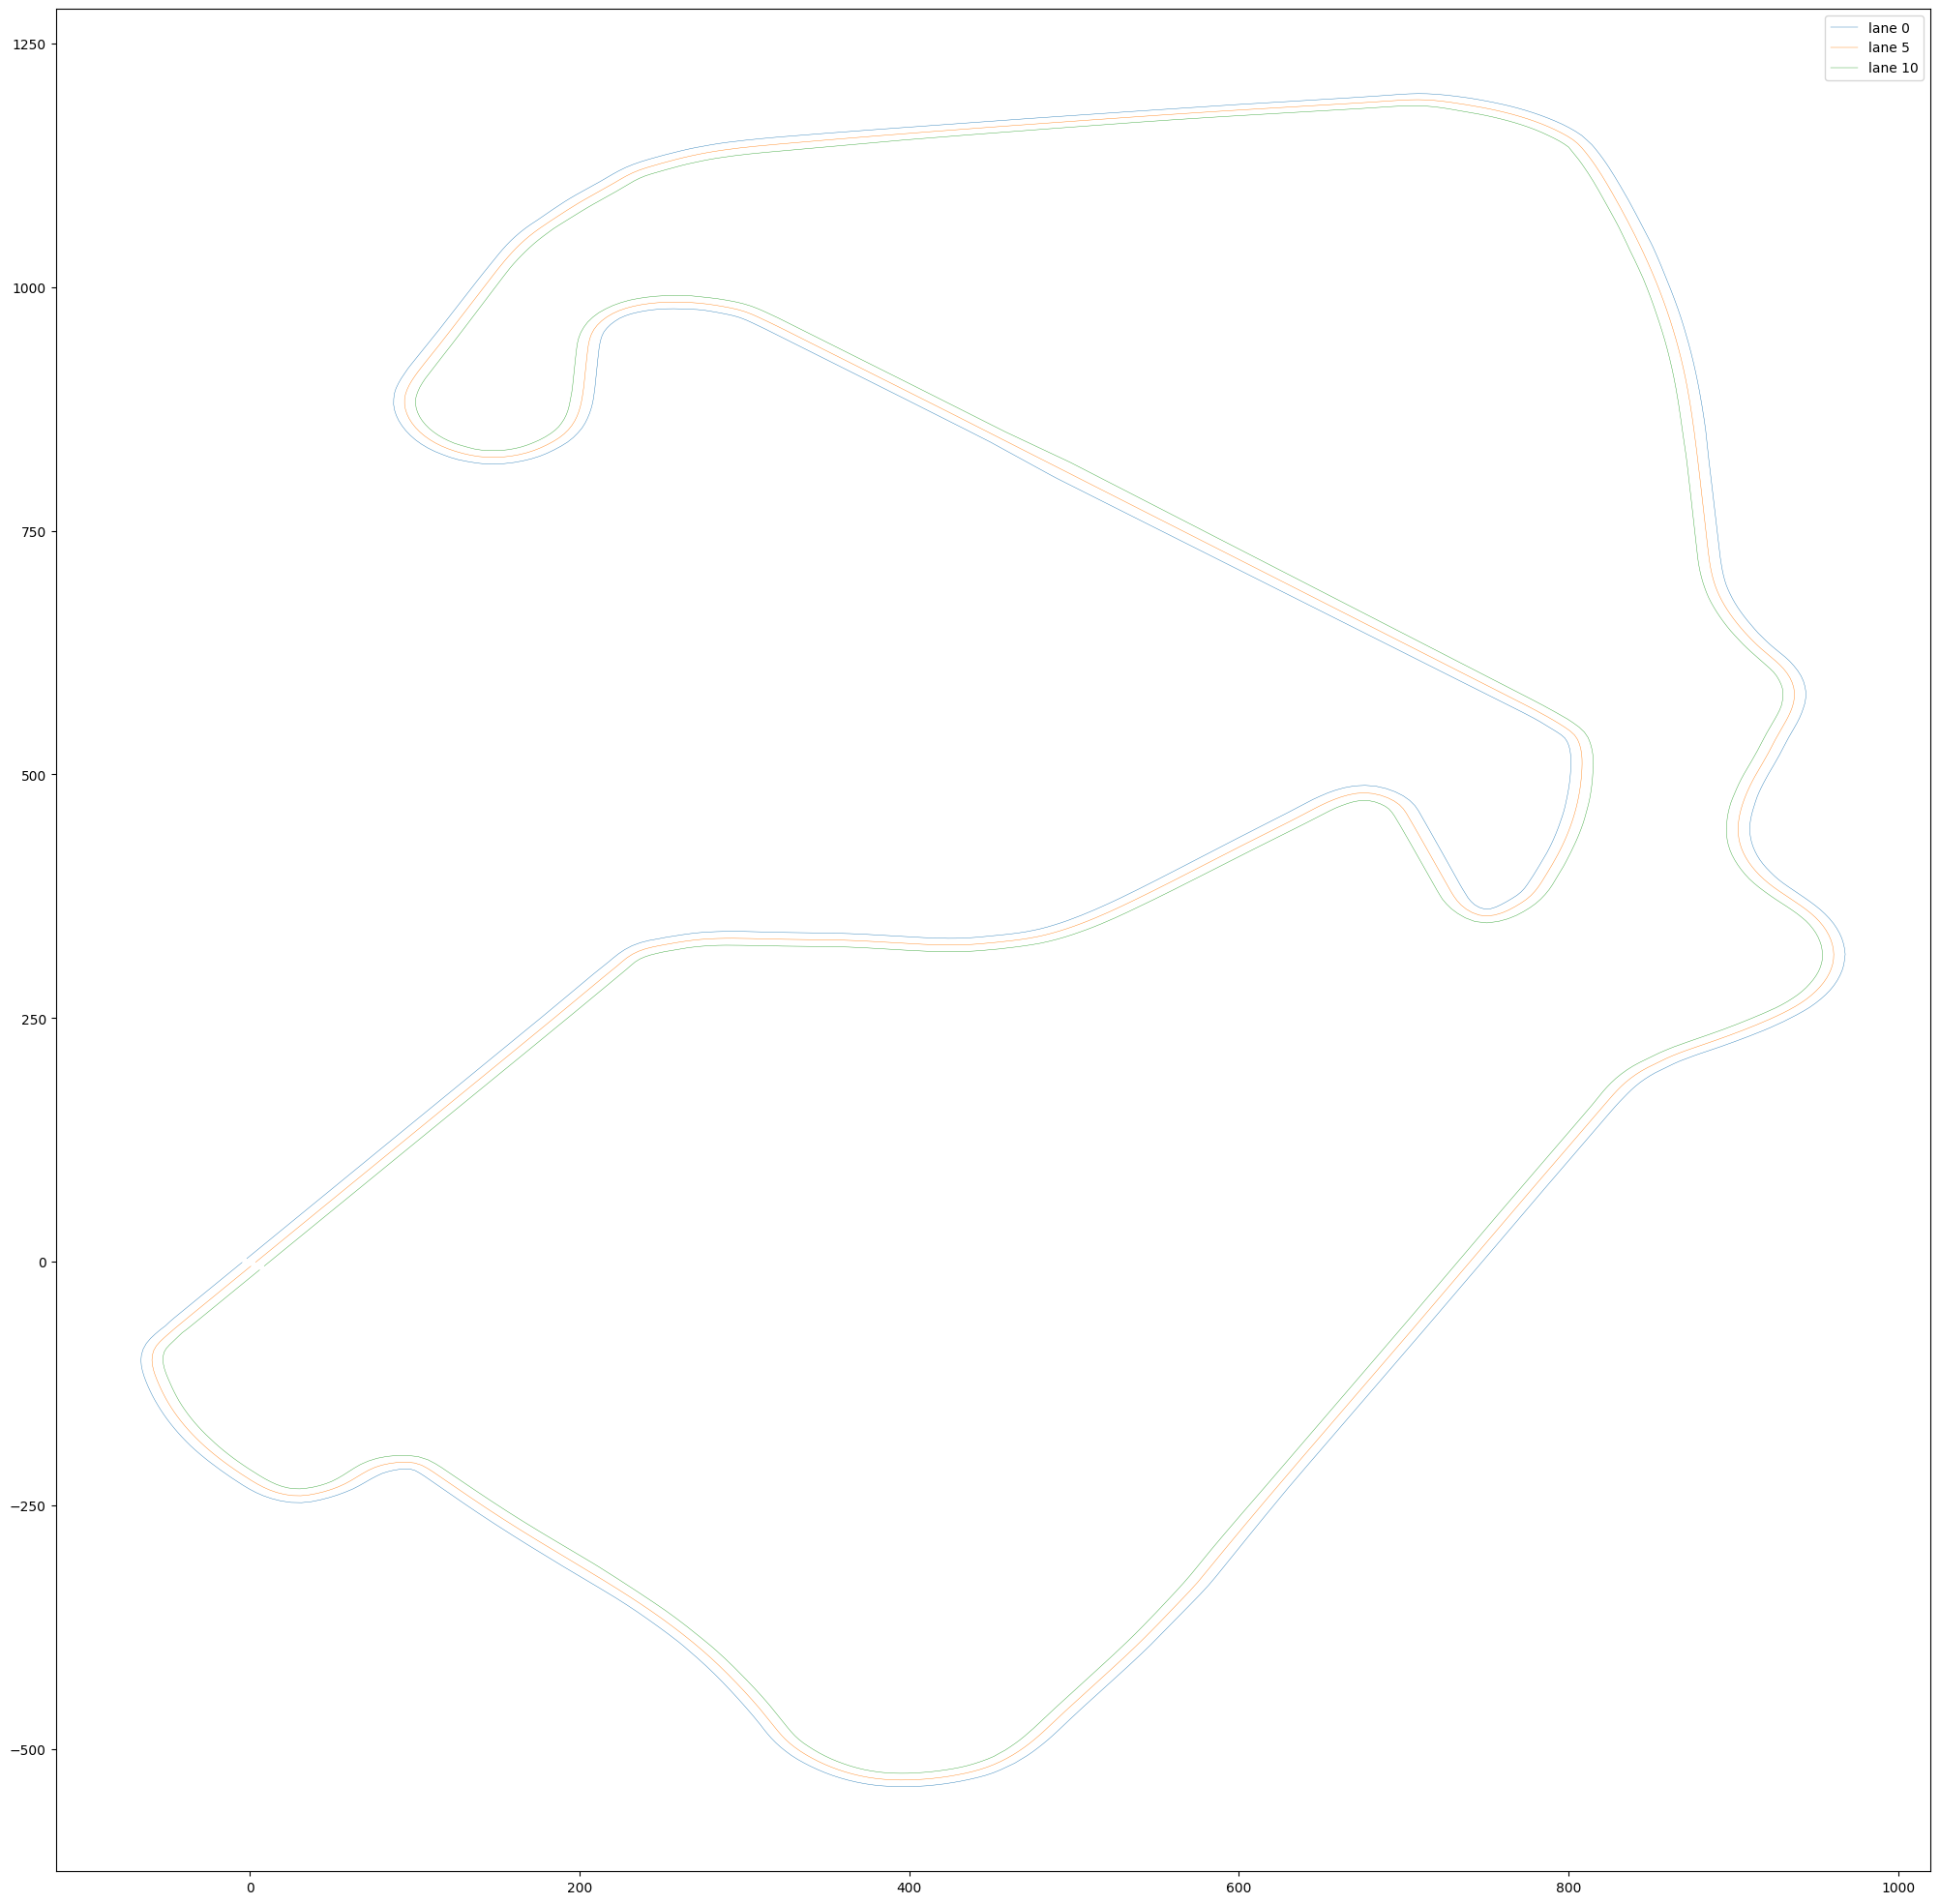

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))

plt.plot(lanesdfd["x_lane0"].to_numpy(),
         lanesdfd["y_lane0"].to_numpy(),
         linewidth=0.3,
         label="lane 0")

plt.plot(lanesdfd["x_lane5"].to_numpy(),
         lanesdfd["y_lane5"].to_numpy(),
         linewidth=0.3,
         label="lane 5")

plt.plot(lanesdfd["x_lane10"].to_numpy(),
         lanesdfd["y_lane10"].to_numpy(),
         linewidth=0.3,
         label="lane 10")

plt.legend()
plt.show()

In [7]:
path = Path("TrackLanes.parquet")
df.write_parquet(path)